In [1]:
# Set environment

import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
import time
from io import BytesIO

from statistics import mean


import deepchem as dc
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors, Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole

from IPython.display import SVG

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# Clustering
import scipy
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 

# Last update 28-05-2023

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (C:\Users\stafasca\Anaconda3\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
# load lipids df (data from Snowflake)
df = pd.read_csv('C:/Users/stafasca/Desktop/SAR_outputs/data_file2.csv', index_col=False)

In [3]:
# Predefined list of functional group structures. 

fg_map = {
             'C/C=C\\C': 'Alkene 1',
             'C/C=C/C': 'Alkene 2',
             'CC=C(C)C': 'Alkene 3',             
             'C=CC': 'Alkene 4',
             'CC#CC': 'Alkyne',
             'C/C=C(C)/C=C/C=C(C)/C=C/C(C)=C(C)C': '????', # long-chain polyunsaturated fatty acid    
    
             'CO': 'Aldehyde',
             'COC': 'Ketone',
             'COC(C)OC': 'Ether',
             'COC(C)=O': 'Ester 1', # Methyl propionate             
             #'CC(=O)OC': 'Ester 2',    isomer of the previous ester           
             'COC(C)OC(C)=O': 'Ester 3',
             'COC(=O)OC': 'Ester 4',    
             
             'CNS(C)(=O)=O': 'Sulfonamide',             
             'CSC(C)=O': 'Thioester 1',             
             'COC(=O)SC': 'Thioester 2', 
             'CSC': 'Thiol',
             'CSSC': 'Disulfide',
    
             # 'CN': 'Primary Amine', # present in 100% of lipids
             #'CNC': 'Secondary Amine', # present in 100% of lipids
             'CN(C)C': 'Tertiary Amine',
             'C[N+](C)(C)C': 'Quat. ammonium',
             'CNC(C)=O': 'Secondary Amide',
             'CC(=O)N(C)C': 'Tertiary Amide 1',            
             'COC(=O)N(C)C': 'Tertiary Amide 2',                         
             'CNC(=N)N': 'Guanidine',                         
             'CNC(=O)OC': 'Carbamate',             
             'Cn1ccnn1': 'Pyridine',            
             'C1CNCCN1': 'Piperazine',
             'C1CCNCC1': 'Piperidine',
             #'C1C(=NCC(=N1)O)O': 'Diketopiperazine' # does not exist in database
             
}


In [4]:
df.head()

,Unnamed: 0,catlipid_id,max_epo_conc_mean_6hr,max_epo_conc_mean_24hr,canonical_smiles,species,CATLIPID_FAMILY_NAME,MOL_WT
0,0,RA17110714,68.003862,48.350963,CCCCC/C=C\C/C=C\CCCCCCC(O)CN(CCCC[C@@H]1NC(=O)...,mice,NaN,1314.130
1,1,RA17131193,66.700000,53.500000,CCCCCCCCC(O)CN(CCCC[C@@H]1NC(=O)[C@@H](CCCCN(C...,mice,NaN,881.405
2,2,RA17138725,66.300000,34.000000,CCCCCCCCCCCOC(=O)CCCC(O)CN(CCCCSSCCCCN1CCN(CCO...,mice,GOOD,1456.370
3,3,RA17132393,54.130000,49.480000,CCCCCCCCCCC(O)CN(CCCCC1NC(=O)C(CCCCN(CC(O)CCCC...,mice,NaN,993.618
4,4,RA16046930,50.120000,NaN,CCCCCCCCCOC(=O)CCCCCCCN(CCO)CCCCCCCC(=O)OC(CCC...,mice,NaN,NaN


In [5]:
# List of predefined likers from LNP-design code

linkers = [
        "NCCOC(=O)cccccc",
        "NCCCOC(=O)COcccccc",
        "NCCCOC(=O)cccccc",
        "NCCCCCOC(=O)",
        "NC~C~C~C~C(=O)OC",
        "NC~C~C~C~C(=O)OCC",
        "NC~C~C~C~C(=O)OCCC",
        "NC~C~C~C(=O)OC",
        "NC~C~C~C(=O)OCC",
        "NC~C~C~C(=O)OCCC",
        "NC~C~C(=O)OC",
        "NC~C~C(=O)OCC",
        "NC~C(=O)OC",
        "NC~C(=O)OCC",
        #"NccC~C~C(=O)OC", # not present in db
        #"nccC~C~C(=O)OC", # not present in db
        #"ncC~C~C(=O)OC", # not present in db
        #"ncC~C(=O)OC", # not present in db
        #"nC~C~C(=O)OC", # not present in db
        #"nC~C(=O)OC", # not present in db
        "NCCC(=O)O",
        "NCCOC(=O)c",
        "NCCCOC(=O)C",
        "NC~CSSCC",
        "NC~CSSC",
    ]



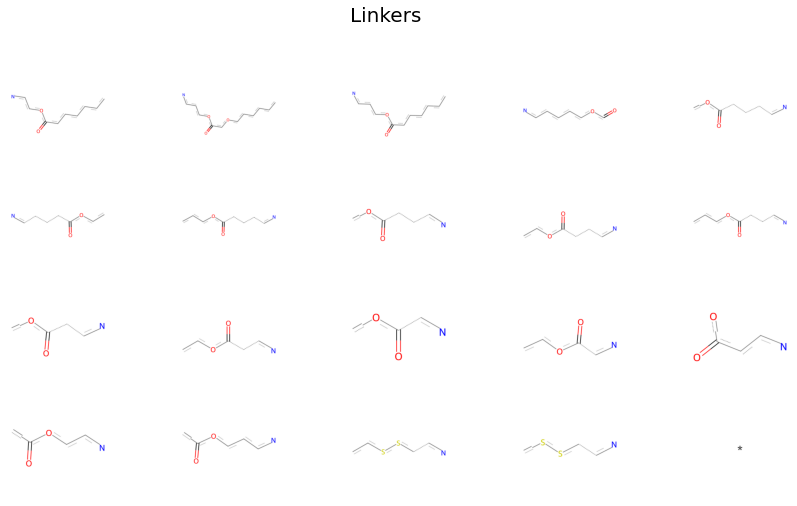

In [6]:
# Display linkers

smiles_list = linkers


# Create a figure with multiple rows of subplots
num_rows = 4
num_cols = len(smiles_list) // num_rows +1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Iterate through each SMILES string and plot the molecule

for i, smiles in enumerate(smiles_list): 
    #print(i)
    mol = Chem.MolFromSmarts(smiles)
    if mol:
        img = Draw.MolToImage(mol)
        row_idx = i // num_cols
        col_idx = i % num_cols        
        ax = axes[row_idx][col_idx]         
        ax.imshow(img)
        #ax.set_title(fg_map[smiles])
        ax.axis('off')
    else:
        mol = Chem.MolFromSmiles("*")
        img = Draw.MolToImage(mol)
        row_idx = i // num_cols
        col_idx = i % num_cols
        ax = axes[row_idx][col_idx]     
        ax.imshow(img)        
        ax.axis('off')

for j in range(i+1,num_rows*num_cols):
    mol = Chem.MolFromSmiles("*")
    img = Draw.MolToImage(mol)
    row_idx = j // num_cols
    col_idx = j % num_cols
    ax = axes[row_idx][col_idx]     
    ax.imshow(img)        
    ax.axis('off')
        
  
#plot 
plt.suptitle("Linkers", fontsize=20)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [7]:
# occurrences of linkers

oc = [0]*len(linkers)

for id_link,link in enumerate(linkers):
    submol = Chem.MolFromSmarts(link)

    for index, row in df.iterrows(): 
        mol = Chem.MolFromSmiles(row.canonical_smiles)
        if mol.HasSubstructMatch(submol): 
            oc[id_link] += 1
oc = np.array(oc)

In [8]:
linkers = np.array(linkers)

In [9]:
oc

array([ 15,   4,  33,   9, 108, 107,  16, 237, 237,  44, 111, 111,  33,
        33, 112,  15,  56, 251, 251])

In [11]:
# FG list
fg_list = [k for k,v in fg_map.items()] 


In [12]:
# OHE of FGs in df

for fg in fg_list:
    submol = Chem.MolFromSmiles(fg)
    lipid_mols = [Chem.MolFromSmiles(sm) for sm in df["canonical_smiles"]]
    df[fg] = [mol.HasSubstructMatch(submol) for mol in lipid_mols]

In [13]:
df.head()

,Unnamed: 0,catlipid_id,max_epo_conc_mean_6hr,max_epo_conc_mean_24hr,canonical_smiles,species,CATLIPID_FAMILY_NAME,MOL_WT,C/C=C\C,C/C=C/C,...,CN(C)C,C[N+](C)(C)C,CNC(C)=O,CC(=O)N(C)C,COC(=O)N(C)C,CNC(=N)N,CNC(=O)OC,Cn1ccnn1,C1CNCCN1,C1CCNCC1
0,0,RA17110714,68.003862,48.350963,CCCCC/C=C\C/C=C\CCCCCCC(O)CN(CCCC[C@@H]1NC(=O)...,mice,NaN,1314.130,True,True,...,True,False,True,False,False,False,False,False,True,False
1,1,RA17131193,66.700000,53.500000,CCCCCCCCC(O)CN(CCCC[C@@H]1NC(=O)[C@@H](CCCCN(C...,mice,NaN,881.405,False,False,...,True,False,True,False,False,False,False,False,True,False
2,2,RA17138725,66.300000,34.000000,CCCCCCCCCCCOC(=O)CCCC(O)CN(CCCCSSCCCCN1CCN(CCO...,mice,GOOD,1456.370,False,False,...,True,False,False,False,False,False,False,False,True,False
3,3,RA17132393,54.130000,49.480000,CCCCCCCCCCC(O)CN(CCCCC1NC(=O)C(CCCCN(CC(O)CCCC...,mice,NaN,993.618,False,False,...,True,False,True,False,False,False,False,False,True,False
4,4,RA16046930,50.120000,NaN,CCCCCCCCCOC(=O)CCCCCCCN(CCO)CCCCCCCC(=O)OC(CCC...,mice,NaN,NaN,False,False,...,True,False,False,False,False,False,False,False,False,False


In [14]:
# OHE of linkers in df
for linker in linkers:
    submol = Chem.MolFromSmarts(linker)
    lipid_mols = [Chem.MolFromSmiles(sm) for sm in df["canonical_smiles"]]
    df[linker] = [mol.HasSubstructMatch(submol) for mol in lipid_mols]

In [15]:
df.head()

,Unnamed: 0,catlipid_id,max_epo_conc_mean_6hr,max_epo_conc_mean_24hr,canonical_smiles,species,CATLIPID_FAMILY_NAME,MOL_WT,C/C=C\C,C/C=C/C,...,NC~C~C~C(=O)OCCC,NC~C~C(=O)OC,NC~C~C(=O)OCC,NC~C(=O)OC,NC~C(=O)OCC,NCCC(=O)O,NCCOC(=O)c,NCCCOC(=O)C,NC~CSSCC,NC~CSSC
0,0,RA17110714,68.003862,48.350963,CCCCC/C=C\C/C=C\CCCCCCC(O)CN(CCCC[C@@H]1NC(=O)...,mice,NaN,1314.130,True,True,...,False,False,False,False,False,False,False,False,False,False
1,1,RA17131193,66.700000,53.500000,CCCCCCCCC(O)CN(CCCC[C@@H]1NC(=O)[C@@H](CCCCN(C...,mice,NaN,881.405,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,RA17138725,66.300000,34.000000,CCCCCCCCCCCOC(=O)CCCC(O)CN(CCCCSSCCCCN1CCN(CCO...,mice,GOOD,1456.370,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,RA17132393,54.130000,49.480000,CCCCCCCCCCC(O)CN(CCCCC1NC(=O)C(CCCCN(CC(O)CCCC...,mice,NaN,993.618,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,RA16046930,50.120000,NaN,CCCCCCCCCOC(=O)CCCCCCCN(CCO)CCCCCCCC(=O)OC(CCC...,mice,NaN,NaN,False,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
# Add tail descriptors to df (run tail descriptor function -last cell- before running this cell)

for id_lip, row in df.iterrows():
    lip_mol = Chem.MolFromSmiles(row.canonical_smiles)
    desc, branches = generate_tail_descriptors_from_mol(lip_mol)
    for k,v in desc.items():
        try:
            df[k][id_lip] = v
        except:
            df[k] = np.nan*len(df)
            df[k][id_lip] = v


C:\Users\stafasca\AppData\Local\Temp\ipykernel_29320\684604376.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k][id_lip] = v
C:\Users\stafasca\AppData\Local\Temp\ipykernel_29320\684604376.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k][id_lip] = v
C:\Users\stafasca\AppData\Local\Temp\ipykernel_29320\684604376.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[k][id_lip] = v
C:\Users\stafasca\AppData\Local\Temp\

In [19]:
df.head()

,Unnamed: 0,catlipid_id,max_epo_conc_mean_6hr,max_epo_conc_mean_24hr,canonical_smiles,species,CATLIPID_FAMILY_NAME,MOL_WT,C/C=C\C,C/C=C/C,...,double_bonds_per_tail,isopropyl_in_tail,branches_in_tails,oxygen_atom_in_tail,disulfide_bond_in_tail,sulfur_atom_in_tail,glycol_in_lipid,branch_length,cyclopropanes_per_tail,rings_in_tail
0,0,RA17110714,68.003862,48.350963,CCCCC/C=C\C/C=C\CCCCCCC(O)CN(CCCC[C@@H]1NC(=O)...,mice,NaN,1314.130,True,True,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,RA17131193,66.700000,53.500000,CCCCCCCCC(O)CN(CCCC[C@@H]1NC(=O)[C@@H](CCCCN(C...,mice,NaN,881.405,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,RA17138725,66.300000,34.000000,CCCCCCCCCCCOC(=O)CCCC(O)CN(CCCCSSCCCCN1CCN(CCO...,mice,GOOD,1456.370,False,False,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0
3,3,RA17132393,54.130000,49.480000,CCCCCCCCCCC(O)CN(CCCCC1NC(=O)C(CCCCN(CC(O)CCCC...,mice,NaN,993.618,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,RA16046930,50.120000,NaN,CCCCCCCCCOC(=O)CCCCCCCN(CCO)CCCCCCCC(=O)OC(CCC...,mice,NaN,NaN,False,False,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,8.0,0.0,0.0


In [119]:
# Generate lipid drawings

# for idx, row in df.iterrows():
#     mol_str = row.canonical_smiles
#     mol = Chem.MolFromSmiles(mol_str)
#     img = Draw.MolToImage(mol, size=(300,300))
#     img.save(f"lipid_images/lipid{idx}.jpg")

In [20]:
# Save df
df.to_csv("C:/Users/stafasca/Documents/SANOFI/App_lipids_SAR/df_fg_tail_desc.csv", sep=',')

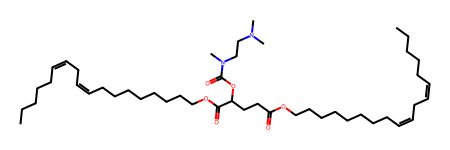

In [21]:
# Draw test lipid
Chem.MolFromSmiles('CCCCC/C=C\C/C=C\CCCCCCCCOC(=O)CCC(OC(=O)N(C)CCN(C)C)C(=O)OCCCCCCCC/C=C\C/C=C\CCCCC')

### Tail descriptors (from LNP-design repo)

In [17]:
import pandas as pd
from rdkit import Chem
from tqdm import tqdm



def find_leaf_atoms(mol: Chem.Mol, species: list) -> set():
    """Returns leaf atoms of a given atom species for a molecule

    Args:
        mol: rdkit molecule object
        species: atom species

    Returns:
        leaves: set of leaf atoms with the given atom species
    """
    leaves = set()

    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        neigs = atom.GetNeighbors()
        neighs_species = set()
        for nei in neigs:
            neighs_species.add(nei.GetSymbol())
        if (
            len(neigs) == 1
            and atom.GetSymbol() in species
            and neighs_species == set(["C"])
        ):
            leaves.add(atom_idx)

    return leaves


def find_atoms_in_rings(mol: Chem.Mol) -> set():
    """Returns all atom ids of atoms involved in rings

    Args:
        mol: rdkit molecule object

    Returns:
        atoms_in_rings: set with the IDs of the atoms in rings
    """
    ring_info = mol.GetRingInfo()
    atom_rings = ring_info.AtomRings()
    atoms_in_rings = set()

    for ring in atom_rings:
        for atom in ring:
            atoms_in_rings.add(atom)

    return atoms_in_rings


def find_branches(
    mol: Chem.Mol, atoms_allowed: list, atoms_in_linkers: set, crosspoints: set
) -> dict:
    """Returns all branches that include only atoms of specific species.
    A branch is a path that leads to a leaf atom.

    Args:
        mol: rdkit molecule object
        atoms_allowed: which atom species are allowed to be present in a branch
        atoms_in_linkers: atom ids of atoms in linkers
        crosspoints: set with atom ids of atoms connected with 4 neighbors

    Returns:
        branches: dictionary leaf -> list of atom ids
    """
    leaves = find_leaf_atoms(mol, ["C"])
    branches = {}

    for atom_id in leaves:
        branches[atom_id] = []
        atom = mol.GetAtomWithIdx(atom_id)
        stack = [atom]
        seen = [0] * mol.GetNumAtoms()
        while stack:
            atom = stack.pop(0)
            seen[atom.GetIdx()] = 1
            neigs = atom.GetNeighbors()
            for nei in neigs:
                if (
                    nei.GetSymbol() in atoms_allowed
                    and not nei.GetIdx() in atoms_in_linkers
                    and not nei.GetIdx() in crosspoints
                ):
                    branches[atom_id].append(nei.GetIdx())
                    if not seen[nei.GetIdx()]:
                        stack.append(nei)
        atoms_in_branch = branches[atom_id]
        branches[atom_id] = list(set(atoms_in_branch))
    short_branches = set()
    for leaf in branches.keys():
        if len(branches[leaf]) < 5:
            short_branches.add(leaf)
    if not len(short_branches) == len(branches.keys()):
        for leaf in short_branches:
            branches.pop(leaf)

    return branches


def remove_equivalent_branches(branches: dict) -> dict:
    """Removes equivalent branches from the branches dictionary.
    Two branches are equivalent if they include exactly the same atom ids.

    Args:
        branches: dictionary leaf -> list of atom ids

    Returns:
        branches: dictionary leaf -> list of atom ids
    """
    to_remove = set()
    to_keep = set()

    for leaf_1 in branches.keys():
        found_equivalent = False
        for leaf_2 in to_keep:
            if not leaf_1 == leaf_2:
                if len(set(branches[leaf_1]).difference(set(branches[leaf_2]))) == 0:
                    found_equivalent = True
        if found_equivalent:
            to_remove.add(leaf_1)
        else:
            to_keep.add(leaf_1)

    for leaf in to_remove:
        branches.pop(leaf)

    return branches


def remove_internal_paths(branches: dict, mol: Chem.Mol, check_for_rings: bool) -> dict:
    """Removes paths that cannot be tails (paths surrounded by N)

    Args:
        branches: dictionary leaf -> list of atom ids
        mol: rdkit molecule object
        check_for_rings: whether the removed paths can include rings

    Returns:
        branches: dictionary leaf -> list of atom ids
    """
    branches_ = branches.copy()
    ring_atoms = find_atoms_in_rings(mol)
    to_remove = set()

    for leaf in branches_.keys():
        branch = branches_[leaf]
        if (
            check_for_rings and len(set(branch).intersection(ring_atoms)) == 0
        ) or not check_for_rings:
            nitrogen_neighbors = 0
            having_nitrogen_neighbors = set()
            for atom_idx in branch:
                atom = mol.GetAtomWithIdx(atom_idx)
                neighbors = atom.GetNeighbors()
                for nei_atom in neighbors:
                    if nei_atom.GetSymbol() == "N":
                        nitrogen_neighbors = nitrogen_neighbors + 1
                        having_nitrogen_neighbors.add(atom_idx)
            if nitrogen_neighbors > 1 and len(having_nitrogen_neighbors) > 1:
                to_remove.add(leaf)

    for leaf in to_remove:
        branches_.pop(leaf)

    return branches_


def remove_glycol_branches(branches: dict, mol: Chem.Mol) -> dict:
    """Removes glycol-containing paths which do not behave like tails

    Args:
        branches: dictionary leaf -> list of atom ids
        mol: rdkit molecule object

    Returns:
        branches: after removing glycol containing paths
    """
    alternating_tails = set()
    branches_ = branches.copy()

    for leaf in branches_.keys():
        branch = branches_[leaf]
        chain = ""
        for atom_idx in branch:
            atom = mol.GetAtomWithIdx(atom_idx)
            chain = chain + atom.GetSymbol()
        if "COCCOCCO" in chain:
            alternating_tails.add(leaf)

    for leaf in alternating_tails:
        branches_.pop(leaf)

    return branches_


def glycol_in_mol(mol: Chem.Mol) -> bool:
    """Returns True if glycol chains are present in a molecule

    Args:
        mol: rdkit molecule object

    Returns:
        True if glycol chains are present otherwise False
    """
    glycol = False
    matches = search_substructure("COCCOCCOC", mol)
    ring_atoms = find_atoms_in_rings(mol)

    for match in matches:
        match_atoms = set(match)
        if len(match_atoms.intersection(ring_atoms)) > 1:
            glycol = False
        else:
            glycol = True

    return glycol


def find_longest_branch_length(branches: dict, mol: Chem.Mol) -> int:
    """Returns the length of the longest path (number of bonds ignoring bond order)

    Args:
        branches: dictionary leaf -> list of atom ids
        mol: rdkit molecule object

    Returns:
        length of longest path
    """
    max_dist = 0
    dists = Chem.rdmolops.GetDistanceMatrix(mol)

    for leaf in branches.keys():
        branch = branches[leaf]
        for atom_1 in branch:
            for atom_2 in branch:
                dist = dists[atom_1, atom_2]
                if dist > max_dist:
                    max_dist = dist

    return max_dist


def count_cyclopropanes(mol):
    """Returns the number of cyclopropanes in a molecule, if any.

    Args:
        mol: rdkit molecule object

    Returns:
        number of cyclopropanes
    """
    ring_info = mol.GetRingInfo()
    atom_rings = ring_info.AtomRings()
    cyclopropanes = 0

    for ring in atom_rings:
        if len(ring) == 3:
            carbon_atoms = 0
            for atom_idx in ring:
                atom = mol.GetAtomWithIdx(atom_idx)
                if atom.GetSymbol() == "C":
                    carbon_atoms = carbon_atoms + 1
            if carbon_atoms == 3:
                cyclopropanes = cyclopropanes + 1

    return cyclopropanes


def characterize_atom_groups(atom_idx: int, mol: Chem.Mol) -> str:
    """Returns a label for a given atom indicating the functional group it is involved in.

    Args:
        atom_idx: atom index
        mol: rdkit molecule object

    Returns:
        label indicating the functional group
    """
    atom = mol.GetAtomWithIdx(atom_idx)
    double_bonded_oxygen = 0
    single_bonded_oxygen = 0
    hydroxyl = False
    single_bonded_carbon = 0
    double_bonded_carbon = 0
    single_bonded_non_oxygen = 0
    double_bonded_non_oxygen = 0
    carbon_leaves = 0
    leaves = find_leaf_atoms(mol, ["C"])
    label = None
    neighbors = atom.GetNeighbors()

    if atom.GetSymbol() == "C":
        for nei_atom in neighbors:
            nei_idx = nei_atom.GetIdx()
            bond = mol.GetBondBetweenAtoms(atom_idx, nei_idx)
            bond = bond.GetBondTypeAsDouble()
            if nei_atom.GetSymbol() == "O":
                if bond == 2:
                    double_bonded_oxygen = double_bonded_oxygen + 1
                elif bond == 1:
                    single_bonded_oxygen = single_bonded_oxygen + 1
                    if len(nei_atom.GetNeighbors()) == 1:
                        hydroxyl = True
            elif nei_atom.GetSymbol() == "C":
                if bond == 2:
                    double_bonded_carbon = double_bonded_carbon + 1
                    double_bonded_non_oxygen = double_bonded_non_oxygen + 1
                elif bond == 1:
                    single_bonded_carbon = single_bonded_carbon + 1
                    single_bonded_non_oxygen = single_bonded_non_oxygen + 1
                    if nei_idx in leaves:
                        carbon_leaves = carbon_leaves + 1
            else:
                if bond == 2:
                    double_bonded_non_oxygen = double_bonded_non_oxygen + 1
                elif bond == 1:
                    single_bonded_non_oxygen = single_bonded_non_oxygen + 1
        if single_bonded_non_oxygen == 2 and double_bonded_oxygen == 1:
            label = "ketone_in_tail"
        elif (
            single_bonded_carbon == 1
            and double_bonded_oxygen == 1
            and single_bonded_oxygen == 1
            and not hydroxyl
        ):
            label = "ester_in_tail"
        elif single_bonded_carbon == 2 and single_bonded_oxygen == 1 and hydroxyl:
            label = "hydroxyl_in_tail"
        if double_bonded_carbon > 0:
            label = "double_bonds_per_tail"
        if carbon_leaves == 2 and len(neighbors) == 3:
            label = "isopropyl_in_tail"
        elif single_bonded_carbon == 3:
            label = "branches_in_tails"
    elif atom.GetSymbol() == "O":
        for nei_atom in neighbors:
            if nei_atom.GetSymbol() == "C":
                single_bonded_carbon = single_bonded_carbon + 1
        if single_bonded_carbon == 2:
            label = "oxygen_atom_in_tail"
    elif atom.GetSymbol() == "S":
        sulfur_neighbor = False
        for nei_atom in neighbors:
            if nei_atom.GetSymbol() == "S":
                sulfur_neighbor = True
        if sulfur_neighbor:
            label = "disulfide_bond_in_tail"
        else:
            label = "sulfur_atom_in_tail"

    return label


def find_atoms_of_species(species: str, mol: Chem.Mol) -> set():
    """Returns IDs of the atoms of a specific atom species

    Args:
        species: atom species (e.g. 'C')
        mol: rdkit molecule object

    Returns:
        atom_ids
    """
    atom_ids = set()

    for atom in mol.GetAtoms():
        if atom.GetSymbol() == species:
            atom_ids.add(atom.GetIdx())

    return atom_ids


def find_rings_without_nitrogen(mol: Chem.Mol) -> set():
    """Returns rings that do not contain nitrogen atoms

    Args:
        mol: rdkit molecule object

    Returns:
        rings_no_nitrogens
    """
    rings_no_nitrogens = set()
    nitrogens = find_atoms_of_species("N", mol)
    ring_info = mol.GetRingInfo()
    atom_rings = ring_info.AtomRings()

    for ring in atom_rings:
        found_N = False
        for atom in ring:
            if atom in nitrogens:
                found_N = True
                break
        if not found_N:
            for atom in ring:
                rings_no_nitrogens.add(atom)

    return rings_no_nitrogens


def search_substructure(smarts: str, mol: Chem.Mol) -> tuple:
    """Substructure search within a molecule

    Args:
        smarts: substructure in SMARTS format
        mol: rdkit molecule object

    Returns:
        substructure matches (tuple)
    """
    structure = Chem.MolFromSmarts(smarts)
    matches = mol.GetSubstructMatches(structure, useChirality=True)

    return matches


def find_crosspoints(mol: Chem.Mol) -> set:
    """Returns crosspoints: atoms with 4 neighbors

    Args:
        mol: rdkit molecule object

    Returns:
        set of atom ids of crosspoint atoms
    """
    crosspoints = set()
    atoms = mol.GetAtoms()

    for atom in atoms:
        neighbors = atom.GetNeighbors()
        if len(neighbors) == 4:
            crosspoints.add(atom.GetIdx())

    return crosspoints


def find_splitpoints(mol):
    """Returns split points: C atoms that are close to a N atom
    and where a split occurs and the tails are starting

    Args:
        mol: rdkit molecule object

    Returns:
        set of split points
    """
    matches = search_substructure(smarts="NCC", mol=mol)
    ring_atoms = find_atoms_in_rings(mol)
    splitpoints = set()

    for match in matches:
        for atom_idx in match:
            atom = mol.GetAtomWithIdx(atom_idx)
            symbol = atom.GetSymbol()
            if (
                symbol == "C"
                and len(atom.GetNeighbors()) > 2
                and atom_idx not in ring_atoms
            ):
                leaf_found = False
                for nei in atom.GetNeighbors():
                    if len(nei.GetNeighbors()) == 1:
                        leaf_found = True
                if not leaf_found:
                    splitpoints.add(atom_idx)

    return splitpoints


def find_connection_with_linker(linker: tuple, mol: Chem.Mol) -> int:
    """Returns the connection point between a linker and a tail

    Args:
        linker: tuple with atom ids in the linker
        mol: rdkit molecule object

    Returns:
        atom_idx of the connecting atom
    """
    connection_points = set()

    for atom_idx in linker:
        atom = mol.GetAtomWithIdx(atom_idx)
        neighbors = atom.GetNeighbors()
        if atom.GetSymbol() == "C" and len(neighbors) == 3:
            single_bonded_O = 0
            double_bonded_O = 0
            single_bonded_C = 0
            for nei_atom in neighbors:
                nei_idx = nei_atom.GetIdx()
                bond = mol.GetBondBetweenAtoms(atom_idx, nei_idx)
                bond = bond.GetBondTypeAsDouble()
                if nei_atom.GetSymbol() == "O":
                    if bond == 2:
                        double_bonded_O = double_bonded_O + 1
                    elif bond == 1:
                        single_bonded_O = single_bonded_O + 1
                elif nei_atom.GetSymbol() == "C":
                    if bond == 1:
                        single_bonded_C = single_bonded_C + 1
            if single_bonded_O == 1 and double_bonded_O == 1 and single_bonded_C == 1:
                continue
            else:
                connection_points.add(atom_idx)

    return connection_points


def find_atoms_in_linkers(pattern: str, mol: Chem.Mol) -> set:
    """Returns the set of atom ids of atoms in linkers

    Args:
        pattern: linker pattern in SMARTS format
        mol: rdkit molecule object

    Returns:
        atom_idx of the connecting atom
    """
    all_linker_atoms = set()
    atoms_in_rings = find_atoms_in_rings(mol)
    matches = search_substructure(pattern, mol)
    branches = find_branches(mol, ["C", "O", "S"], set(), set())
    branch_atoms = set()
    for leaf in branches.keys():
        branch_atoms = branch_atoms.union(set(branches[leaf]))

    if len(matches) > 0:
        for match in matches:
            linker_atoms = set()
            crosspoints = find_connection_with_linker(match, mol)
            if not len(crosspoints) == 0:
                pattern_with_ring = pattern + "CCCO"
                matches_with_ring = search_substructure(pattern_with_ring, mol)
                if len(matches_with_ring) == 0:
                    pattern_with_ring = pattern + "ccccc"
                    matches_with_ring = search_substructure(pattern_with_ring, mol)
                confirmed_matches_wr = set()
                if len(matches_with_ring) > 0:
                    for match_wr in matches_with_ring:
                        if (
                            len(atoms_in_rings.intersection(set(match_wr))) == 5
                            or len(atoms_in_rings.intersection(set(match_wr))) == 6
                        ):
                            confirmed_matches_wr.add(match_wr)
                if len(confirmed_matches_wr) > 0:
                    crosspoints = set()
                    for match in confirmed_matches_wr:
                        crosspoints = crosspoints.union(
                            find_connection_with_linker(match, mol)
                        )
                        for atom_idx in match:
                            if atom_idx not in crosspoints:
                                linker_atoms.add(atom_idx)
                else:
                    for atom_idx in match:
                        if atom_idx not in crosspoints:
                            linker_atoms.add(atom_idx)

                branches = find_branches(mol, ["C", "O", "S"], linker_atoms, set())
                branch_atoms = set()
                for leaf in branches.keys():
                    branch_atoms = branch_atoms.union(set(branches[leaf]))
                if len(crosspoints.intersection(branch_atoms)) == 0:
                    linker_atoms = set()
                else:
                    for crosspoint in crosspoints:
                        linker_atoms.add(crosspoint)
                    all_linker_atoms = all_linker_atoms.union(linker_atoms)

    return all_linker_atoms


def generate_tail_descriptors_from_mol(mol: Chem.Mol):
    """It returns the atom ids of the atoms in tails
    It also extract features from the lipid tail
    Note: This function may not be accurate for non-symmetric lipids
    (Family 12 for example has lipids with non-symetrical tails)

    Args:
        mol: rdkit molecule object (assuming it represents a lipid)

    Returns:
        tail_descriptors: features extracted from tails
        branches: tails
    """
    linker_patterns = [
        "NCCOC(=O)cccccc",
        "NCCCOC(=O)COcccccc",
        "NCCCOC(=O)cccccc",
        "NCCCCCOC(=O)",
        "NC~C~C~C~C(=O)OC",
        "NC~C~C~C~C(=O)OCC",
        "NC~C~C~C~C(=O)OCCC",
        "NC~C~C~C(=O)OC",
        "NC~C~C~C(=O)OCC",
        "NC~C~C~C(=O)OCCC",
        "NC~C~C(=O)OC",
        "NC~C~C(=O)OCC",
        "NC~C(=O)OC",
        "NC~C(=O)OCC",
        "NccC~C~C(=O)OC",
        "nccC~C~C(=O)OC",
        "ncC~C~C(=O)OC",
        "ncC~C(=O)OC",
        "nC~C~C(=O)OC",
        "nC~C(=O)OC",
        "NCCC(=O)O",
        "NCCOC(=O)c",
        "NCCCOC(=O)C",
        "NC~CSSCC",
        "NC~CSSC",
    ]
    atoms_in_linkers = set()
    for chain in linker_patterns:
        linkers = find_atoms_in_linkers(chain, mol)
        if len(linkers) > 0:
            # print(chain)
            atoms_in_linkers = linkers
            break
    crosspoints = find_crosspoints(mol)
    splitpoints = find_splitpoints(mol)
    crosspoints = crosspoints.union(splitpoints)

    branches = find_branches(mol, ["C", "O", "S"], atoms_in_linkers, crosspoints)
    leaves = set(branches.keys())

    before_filtering_glycols = len(branches)
    if len(remove_glycol_branches(branches, mol)) > 0:
        branches = remove_glycol_branches(branches, mol)
    after_filtering_glycols = len(branches)

    branches = remove_equivalent_branches(branches)

    if len(remove_internal_paths(branches, mol, True)) > 0:
        branches = remove_internal_paths(branches, mol, True)
    elif len(remove_internal_paths(branches, mol, False)) > 0:
        branches = remove_internal_paths(branches, mol, False)

    tail_descriptors = {
        "num_tails": 0,
        "max_tail_length": 0,
        "ketone_in_tail": 0,
        "ester_in_tail": 0,
        "hydroxyl_in_tail": 0,
        "double_bonds_per_tail": 0,
        "isopropyl_in_tail": 0,
        "branches_in_tails": 0,
        "oxygen_atom_in_tail": 0,
        "disulfide_bond_in_tail": 0,
        "sulfur_atom_in_tail": 0,
        "glycol_in_lipid": 0,
        "branch_length": 0,
        "cyclopropanes_per_tail": 0,  # cyclopropanes can be anywhere in the mol
        # TODO: change function to detect cyclopropanes only in tail???
    }

    all_atoms_in_branches = set()
    for leaf in branches.keys():
        all_atoms_in_branches = all_atoms_in_branches.union(branches[leaf])

    number_of_tails = len(branches)
    tail_descriptors["num_tails"] = number_of_tails
    max_tail_length = find_longest_branch_length(branches, mol)
    tail_descriptors["max_tail_length"] = max_tail_length

    if after_filtering_glycols < before_filtering_glycols or glycol_in_mol(mol):
        tail_descriptors["glycol_in_lipid"] = 1
    for leaf in branches.keys():
        branch = branches[leaf]
        for atom in branch:
            label = characterize_atom_groups(atom, mol)
            if label is not None and not label == "double_bonds_per_tail":
                tail_descriptors[label] = 1
            elif label == "double_bonds_per_tail":
                tail_descriptors[label] = tail_descriptors[label] + 1
    tail_descriptors["double_bonds_per_tail"] = (
        tail_descriptors["double_bonds_per_tail"] / 2
    )

    ring_atoms = find_atoms_in_rings(mol)
    tail_descriptors["rings_in_tail"] = 0

    if len(all_atoms_in_branches.intersection(ring_atoms)) > 4:
        tail_descriptors["rings_in_tail"] = 1
        tail_descriptors["branches_in_tails"] = 0

    if tail_descriptors["branches_in_tails"] == 1:
        tail_descriptors["branch_length"] = get_branch_length(mol, branches)

    if number_of_tails > 0:
        tail_descriptors["cyclopropanes_per_tail"] = (
            count_cyclopropanes(mol) / number_of_tails
        )

        tail_descriptors["double_bonds_per_tail"] = (
            tail_descriptors["double_bonds_per_tail"] / number_of_tails
        )

    if tail_descriptors["cyclopropanes_per_tail"] > 0:
        tail_descriptors["rings_in_tail"] = 0

    for leaf in branches.keys():
        branch = set(branches[leaf])
        if (
            len(branch.intersection(leaves)) == 2
            and tail_descriptors["branches_in_tails"] == 0
            and tail_descriptors["isopropyl_in_tail"] == 0
        ):
            tail_descriptors["branches_in_tails"] = 1
            tail_descriptors["branch_length"] = int(
                max_tail_length / 2
            )  # approximation

    return tail_descriptors, branches


def generate_tail_descriptors(
    molecules: pd.DataFrame, id_col: str = "catlipid_id"
) -> pd.DataFrame:
    """
    Computes all tail descriptors for all molecules in a dataframe.

    Args:
        molecules: dataframe with rdkit molecule objects.
        id_col: column name of the column that contains the molecule ids.

    Returns:
        dataframe with tail descriptors including the molecule ids.
    """
    logger.info("Generating lipid tail descriptors.")
    tail_descriptors = []
    for mol in tqdm(molecules["molecule_object"]):
        descriptors, _ = generate_tail_descriptors_from_mol(mol)
        tail_descriptors.append(descriptors)

    tail_descriptors = pd.DataFrame(tail_descriptors)

    if id_col is not None:
        tail_descriptors = pd.concat([molecules[id_col], tail_descriptors], axis=1)

    return tail_descriptors


def get_distance_from_leaf(atom_idx: int, mol: Chem.Mol) -> int:
    """It returns the height of an atom in the molecular graph,
    that is, the distance from the closest leaf atom.

    Args:
        atom_idx: atom index of the atom
        mol: rdkit molecule object (assuming it represents a lipid)

    Returns:
        min_dist_from_leaf: distance of the given atom from the closest leaf atom
    """
    leaves = find_leaf_atoms(mol, ["C"])
    dists = Chem.rdmolops.GetDistanceMatrix(mol)
    min_dist_from_leaf = 100

    for leaf in leaves:
        if dists[leaf, atom_idx] < min_dist_from_leaf:
            min_dist_from_leaf = dists[leaf, atom_idx]

    return min_dist_from_leaf


def order_atoms_in_tails(mol: Chem.Mol, tails: dict) -> Chem.Mol:
    """It orders the atoms in the tails (by assigning a property "order"),
    the order indicates the distance of an atom from the leaf atom in the tail.

    Args:
        mol: rdkit molecule object (assuming it represents a lipid)
        tails: dictionary: leaf atom -> list of atoms

    Returns:
        mol: molecule with each atom having a property that indicates the order.
    """
    for leaf in tails.keys():
        tail = tails[leaf]
        for atom_idx in tail:
            atom = mol.GetAtomWithIdx(atom_idx)
            dist_from_leaf = get_distance_from_leaf(atom_idx, mol)
            atom.SetProp("order", str(dist_from_leaf))

    return mol


def find_atoms_at_location(mol: Chem.Mol, tail: list, location: int) -> int:
    """It returns the atom ids of the atoms that are at a given location,
    the location is the distance from the closest leaf.

    Args:
        mol: rdkit molecule object (assuming it represents a lipid)
        tail: list of atom ids in the tail
        location: distance from leaf atom in the tail

    Returns:
        atoms_found: atom ids of atoms found at the given location
    """
    atoms_found = set()

    for atom_idx in tail:
        atom = mol.GetAtomWithIdx(atom_idx)
        if atom.HasProp("order"):
            order = int(atom.GetProp("order").replace(".0", ""))
            if order == location:
                atoms_found.add(atom_idx)

    return atoms_found


def get_branch_length(mol: Chem.Mol, tails: dict) -> int:
    """Returns the length of the branch in a tail (distance from leaf atom)

    Args:
        mol: rdkit molecule object (assuming it represents a lipid)
        tails: dictionary: leaf atom -> list of atoms

    Returns:
        max_length: maximum length between two atoms in a branch
    """
    max_length = 0

    for leaf in tails.keys():
        tail = tails[leaf]
        atom_idx = leaf
        found_branch = False
        counter = -1
        visited = set()
        while not found_branch and counter < len(tail):
            counter = counter + 1
            atom = mol.GetAtomWithIdx(atom_idx)
            visited.add(atom_idx)
            neighbors = atom.GetNeighbors()
            if len(neighbors) > 2 and not counter == 1:
                found_branch = True
            else:
                for nei in neighbors:
                    nei_idx = nei.GetIdx()
                    if nei_idx not in visited:
                        atom_idx = nei_idx

        if counter > max_length:
            max_length = counter

        return max_length


def get_all_tail_atoms(tails: dict) -> set:
    """Returns the set of all atom ids of the atoms in the tails

    Args:
        tails: dictionary: leaf atom -> list of atoms

    Returns:
        all_atoms_in_tails:
    """
    all_atoms_in_tails = set()

    for leaf in tails.keys():
        tail = tails[leaf]
        for atom in tail:
            all_atoms_in_tails.add(atom)

    return all_atoms_in_tails


def is_atom_clean(atom_idx: int, mol: Chem.Mol, check_neighbors: bool) -> bool:
    """Checks whether an atom, and optionaly its neighbors, are clean from
    functional groups and are of species other than C.

    Args:
        atom_idx: atom index of the atom defining the center of the neighborhood.
        mol: rdkit molecule object.
        check_neighbors: if True then the neighboring atoms are also checked.

    Returns:
        clean_atom: True if the atom is of species C and no functional groups
        are attached to it.
    """
    clean_atom = True

    label = characterize_atom_groups(atom_idx, mol)
    if label is not None:
        clean_atom = False
    elif check_neighbors:
        atom = mol.GetAtomWithIdx(atom_idx)
        for nei in atom.GetNeighbors():
            nei_idx = nei.GetIdx()
            label = characterize_atom_groups(nei_idx, mol)
            if label is not None:
                clean_atom = False
                break

    return clean_atom


def find_species_neighbors(mol: Chem.Mol, species: str) -> set:
    """Returns the atom ids of the atoms that are bonded with atoms of a given species.

    Args:
        mol: rdkit molecule object.
        species: atom species for which we search for neighbors (e.g. "O" or "N").

    Returns:
        neighbors: atom ids of the atoms adjacent to atoms of the given species.
    """
    neighbors = set()

    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        for nei in atom.GetNeighbors():
            if nei.GetSymbol() == species:
                neighbors.add(atom_idx)

    return neighbors



mol = Chem.MolFromSmiles(
    "CCCCC/C=C\C/C=C\CCCCCCCCOC(=O)CCC(OC(=O)N(C)CCN(C)C)C(=O)OCCCCCCCC/C=C\C/C=C\CCCCC"
)
desc, branches = generate_tail_descriptors_from_mol(mol)
print("tail descriptors", desc)
print("branches", branches)


tail descriptors {'num_tails': 1, 'max_tail_length': 42.0, 'ketone_in_tail': 0, 'ester_in_tail': 1, 'hydroxyl_in_tail': 0, 'double_bonds_per_tail': 4.0, 'isopropyl_in_tail': 0, 'branches_in_tails': 1, 'oxygen_atom_in_tail': 1, 'disulfide_bond_in_tail': 0, 'sulfur_atom_in_tail': 0, 'glycol_in_lipid': 0, 'branch_length': 21, 'cyclopropanes_per_tail': 0.0, 'rings_in_tail': 0}
branches {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]}
